# IFT 6758 - Devoir 3 

### Pt 2. Classement d'éches
**Comparaison des groupes sur/sous-représentés**

Evaluation de ce notebook :

- Graphiques pour les distributions de scores et d'écarts
- Résultats imprimés des tests de permutation
- Réponses courtes (dernière section)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import chess_rating

/Users/etiennecollin/github/ift3700/devoir-3/chess_rating.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## 1. Chargez les données

### 1.1 Lire les données XML

In [4]:
xml_path = Path("data/standard_oct22frl_xml.xml")  # shouldn't need to change this

In [5]:
raw_df = chess_rating.parse_xml(xml_path)

In [6]:
# Vérifiez pour voir un échantillon de 5 joueurs
np.random.seed(0)
raw_df.sample(5)

,name,rating,sex,birthday,country,flag,title
181915,"Kouchaki Pirkouhi, Mohsen",1283,M,1990,IRI,None,None
159415,"Jonsson, Alfred",1680,M,1995,SWE,None,None
228502,"Mikhailova, Veronika",1117,F,2008,RUS,w,None
131173,"Guk, Evgeniy",2062,M,1937,RUS,i,None
93274,"D`Ambrosio, Francesco",1420,M,1937,ITA,i,None


In [7]:
# Vérifiez pour voir les dtypes du dataframe brut
raw_df.dtypes

name        object
rating      object
sex         object
birthday    object
country     object
flag        object
title       object
dtype: object

In [8]:
# Voir il y a combien de dates de naissance manquantes
raw_df.birthday.isnull().sum()

np.int64(8477)

### 1.2 Nettoyez les données

Nous voulons que les anniversaires (année de naissance) et le score (Elo) soient convertis en nombres entiers afin que nous puissions faire des opérations numériques/logiques avec eux (par exemple, moins que, plus grand que, etc.). Complétez la méthode `clean_data()` dans `chess_rating.py`

In [9]:
df = chess_rating.clean_data(raw_df, 2002)

/Users/etiennecollin/github/ift3700/devoir-3/chess_rating.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["birthday", "rating"]] = df[["birthday", "rating"]].astype(int)


In [10]:
np.random.seed(0)
df.sample(5)

,name,rating,sex,birthday,country,flag,title
206801,"Lutzen, Mads",1542,M,2000,DEN,i,None
296314,"Rieckers, Dirk",1397,M,1964,GER,i,None
120235,"Gil, Celsio",1752,M,1999,STP,i,None
147860,"Hurwitz, Ed J G",2023,M,1964,ENG,i,None
124743,"Gonzalez Gomez, Pedro Daniel",1539,M,1997,ESP,None,None


In [11]:
df.dtypes

name        object
rating       int64
sex         object
birthday     int64
country     object
flag        object
title       object
dtype: object

In [12]:
df.birthday.isnull().sum()

np.int64(0)

## 2. Histogrammes des scores Elo

Nous voulons d'abord comparer la distribution des scores pour les joueurs masculins et féminins.
Étant donné que les données sont assez fines, nous devrons regrouper les notes.
Complétez `bin_counts()`, qui devrait gérer le binning pour les données arbitraires et le choix des bacs.
En plus de renvoyer les décomptes bruts, renvoyez également les décomptes normalisés dans la trame de données (`"count_norm"`).

### 2.1 Binning data

Voici quelques entrées de test pour vous aider à valider votre implémentation :

In [13]:
# sample inputs to help test your method
x = pd.DataFrame({'rating': [1, 2, 4, 6, 6, 7, 8, 11] })
bins = [0, 5, 10, 15]
bin_centers = [2.5, 7.5, 12.5]

# Output attendu
solution = pd.DataFrame({
    'rating': {0: 7.5, 1: 2.5, 2: 12.5},
     'count': {0: 4, 1: 3, 2: 1},
     'count_norm': {0: 0.5, 1: 0.375, 2: 0.125}
})

In [14]:
binned_output = chess_rating.bin_counts(x, bins, bin_centers)
print(binned_output)

  rating  count  count_norm
0    7.5      4       0.500
1    2.5      3       0.375
2   12.5      1       0.125


/Users/etiennecollin/github/ift3700/devoir-3/chess_rating.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hist = df.groupby(bins).size().reset_index(name="count")


In [15]:
solution.eq(binned_output)

,rating,count,count_norm
0,True,True,True
1,True,True,True
2,True,True,True


Utilisons cette méthode pour bin les scores M/F et les comparer.

In [16]:
rating_range_start = 1000
rating_range_stop = 2900
bin_size = 50

bins = [i for i in range(rating_range_start, rating_range_stop+1, bin_size)]
bin_centers = [i for i in range(rating_range_start + bin_size//2, rating_range_stop+1, bin_size)]

In [17]:
# Générez les données d'histogramme  
M_hist = chess_rating.bin_counts(df.query("sex=='M'"), bins=bins, bin_centers=bin_centers)
F_hist = chess_rating.bin_counts(df.query("sex=='F'"), bins=bins, bin_centers=bin_centers)

M_hist['sex'] = 'M'
F_hist['sex'] = 'F'

hist = pd.concat([M_hist, F_hist])

/Users/etiennecollin/github/ift3700/devoir-3/chess_rating.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hist = df.groupby(bins).size().reset_index(name="count")
/Users/etiennecollin/github/ift3700/devoir-3/chess_rating.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hist = df.groupby(bins).size().reset_index(name="count")


À l'aide des données regroupées, tracez deux graphiques linéaires des données regroupées côte à côte; l'un contenant les décomptes bruts (`"count"`), et l'autre contenant les décomptes normalisés (`"count_norm"`), et M/F doit être de deux couleurs différentes.

<Axes: xlabel='rating', ylabel='count_norm'>

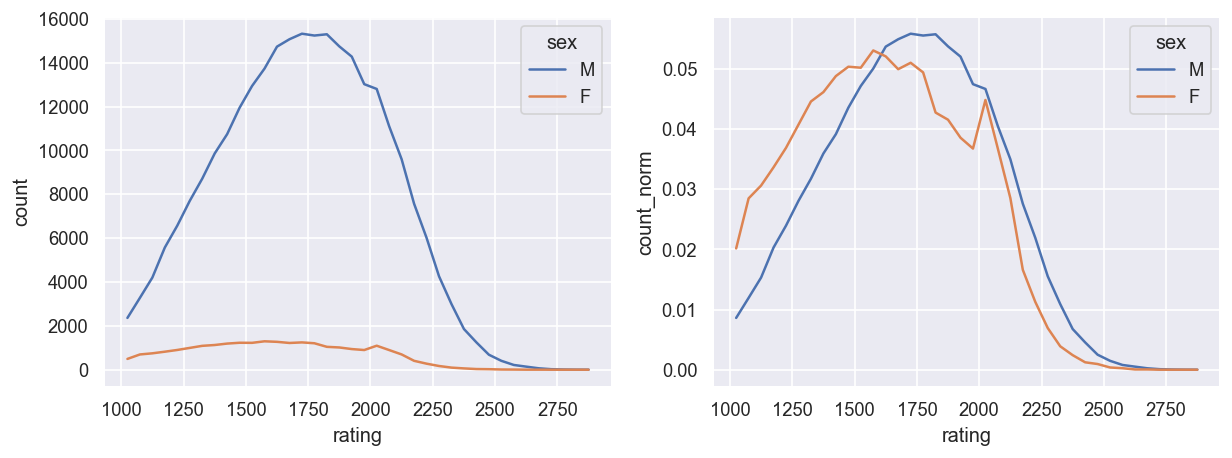

In [18]:
# Now draw the two histograms side-by-side. 
fig, ax = plt.subplots(1,2, figsize=(12, 4), dpi=120)
sns.lineplot(data=hist, x="rating", y="count", hue='sex', ax=ax[0])
sns.lineplot(data=hist, x="rating", y="count_norm", hue='sex', ax=ax[1])

## 3. Tests de Permutation

Nous allons maintenant effectuer les tests de permutation comme indiqué dans l'expérience de pensée de l'introduction.
Prenez l'ensemble de données nettoyé complet (hommes et femmes) et échantillonnez au hasard deux groupes sans remplacement (c'est-à-dire mélangez les joueurs).
La taille des groupes doit refléter la différence du monde réel que nous souhaitons étudier, c'est-à-dire la taille du groupe masculin et féminin.
Terminez `chess_rating.PermutationTests.job()`, qui implémente la partie échantillonnage de cette expérience, et renvoie la valeur maximale des groupes surreprésentés et sous-représentés respectivement.

Ensuite, complétez la méthode `chess_rating.sample_two_groups()`, qui exécute cette expérience `n_iter` fois.
Une fois terminé, exécutez cette expérience dans le bloc-notes avec au moins `n_iter=1000`.
Exécutez la cellule qui imprime la différence moyenne obtenue à partir des tests de permutation, ainsi que les différences réelles.

In [19]:
n_overrep = df.query("sex=='M'").rating.count()
n_underrep = df.query("sex=='F'").rating.count()

over, under = chess_rating.sample_two_groups(df, n_overrep, n_underrep, n_iter=1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.65it/s]


In [20]:
diffs = over - under
max_M, max_F = df.query("sex=='M'").rating.max(), df.query("sex=='F'").rating.max()

In [21]:
print(f"Mean difference between top individuals in the over/under represented groups taken from the permutation experiments:")
print(f"\n\t{diffs.mean()} (std={diffs.std().round(2)})")
print()
print("Real values:\n")
print(f"\tMax M:\t\t{max_M}")
print(f"\tMax F:\t\t{max_F}")
print(f"\tReal difference: {max_M - max_F}")

Mean difference between top individuals in the over/under represented groups taken from the permutation experiments:

	85.983 (std=50.93)

Real values:

	Max M:		2856
	Max F:		2675
	Real difference: 181


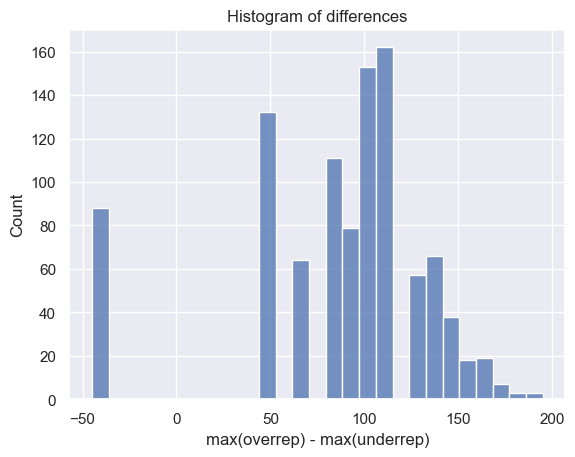

In [22]:
fig, ax = plt.subplots(1, 1, dpi=100)
sns.histplot(diffs, ax=ax).set(title="Histogram of differences", xlabel="max(overrep) - max(underrep)");

# Questions 

Donnez des réponses courtes aux questions suivantes (1-3 lignes chaques).

1. Interprétez les résultats - pouvez-vous tirer une conclusion? Rappelez-vous que l'affirmation discutée dans l'introduction de cette question était "les hommes sont meilleurs que les femmes aux échecs parce que la plupart des meilleurs joueurs sont des hommes". (Remarque : probablement une partie de votre réponse ici sera liée à votre réponse à la question suivante.)
    - Selon notre analyse, il semble que les hommes obtiennent des scores significativement plus élevés que les femmes aux échecs. Le test de permutations indique qu'on devrait s'attendre à une différence moyenne de 85.983 points entre les deux groupes (s'ils provenaient d'une "même" distribution), avec un écart-type de 50.93 points. Ainsi, la différence réelle observée entre les scores des hommes et des femmes se situe près de deux écarts-types au-delà de cette moyenne. Cela suggère qu'il est peu probable que cette différence soit simplement le résultat d'une variation aléatoire. En effet, la différence est statistiquement significative et ne peut pas être ignorée. Si on se fie uniquement à ce test, on pourrait conclure que les hommes sont globalement meilleurs que les femmes aux échecs parce que la plupart des meilleurs joueurs sont des hommes.

3. Pensez-vous que les chiffres obtenus ici racontent toute l'histoire? Quels pourraient être les problèmes avec l'analyse menée ici? Les données avec lesquelles nous travaillons sont-elles biaisées d'une quelconque manière (autre qu'un biais de surreprésentation)? L'ELO est-il une bonne mesure et peut-il être utilisé pour répondre à la question initiale? Existe-t-il des différences dans le traitement social, culturel et systémique des hommes et des femmes qui peuvent empêcher le groupe sous-représenté d'obtenir des résultats similaires? Rien d'autre?
    - L’analyse s’appuie sur des tests de permutations pour expliquer les différences de scores entre les hommes et les femmes, mais ces tests ne tiennent pas compte d’autres facteurs sociaux, historiques ou démographiques qui peuvent influencer la performance aux échecs. Ils mesurent une différence numérique dans les scores (ELO) sans examiner les causes sous-jacentes.
        - Les échecs ont longtemps été un domaine dominé par les hommes, avec moins de femmes participant aux compétitions et aux formations de haut niveau. Ce manque d'opportunités historiques pourrait fausser les données actuelles, car les femmes ont souvent eu moins d'accès aux mêmes ressources, compétitions et réseaux de soutien que les hommes.
        - Si les femmes ont moins d'opportunités de jouer contre des joueurs de haut niveau, leur ELO pourrait rester plus bas, même si elles ont le même potentiel.
        - Le nombre de femmes jouant aux échecs à un niveau professionnel est plus faible, ce qui pourrait créer un effet de sous-échantillonnage où la variation dans les performances des femmes semble plus faible simplement en raison du nombre limité de joueuses dans les échantillons analysés. Le test de permutations ne crée pas vraiment deux nouveaux échantillons aléatoires de populations et ne peut pas complètement régler ce problème.
        - Le manque de soutien institutionnel, l’inégalité d'accès aux entraînements de qualité ou aux compétitions, ainsi que les préjugés explicites ou implicites envers les femmes peuvent aussi limiter leurs opportunités de progression.
        - Il y a peu de modèles féminins dans les échecs, ce qui pourrait limiter l'inspiration et la motivation des jeunes filles à s'engager sérieusement dans ce domaine.
    - Si le ELO est un score standardisé pour les homme et les femmes, alors c'est une mesure de performance qui peut être fiable. Notre analyse se concentre uniquement sur les scores des meilleurs joueurs et joueuses, mais il est important de noter que très peu d'individus, hommes ou femmes, atteignent un tel niveau. Une approche plus pertinente et informative consisterait à comparer les scores moyens des joueurs et des joueuses à travers différentes catégories de classement ou en fonction de leur niveau d'expérience. Cela offrirait une vision plus complète et nuancée des performances globales.


Le but de ces questions est de souligner que les données sont une représentation limitée du monde réel. Il est essentiel pour nous, en tant que scientifiques des données, de prendre du recul lorsque nous examinons un résultat et de réfléchir à la façon dont il est lié au monde réel, plutôt que de simplement supposer naïvement que les données et la configuration expérimentale sont bonnes, ce qui entraîne souvent des conclusions erronées/incorrectes. Il pourrait y avoir plusieurs facteurs de causalité qui expliquent une relation qui sont indépendants de l'hypothèse d'origine: utilisation de données qui ne reflètent pas vraiment l'hypothèse que vous souhaitez tester, données biaisées (y compris les groupes surreprésentés), différences systémiques réelles entre les groupes, etc.